"Frequent consumption of high caloric food (FAVC), Frequency of consumption of vegetables (FCVC), Number of main meals (NCP), Consumption of food between meals (CAEC), Consumption of water daily (CH20), and Consumption of alcohol (CALC). The attributes related with the physical condition are: Calories consumption monitoring (SCC), Physical activity frequency (FAF), Time using technology devices (TUE), Transportation used (MTRANS),"

In [747]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn import tree

In [748]:
data = pd.read_csv("ObesityDataSet_raw.csv")
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [751]:
data['NObeyesdad'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [713]:
data.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [714]:
data['NObeyesdad'].value_counts()

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: NObeyesdad, dtype: int64

In [715]:
null_count_by_col = (data.isnull().sum())
null_count_by_col

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [753]:
replace_dict = {'Obesity_Type_I' : 'Obesity',
                'Obesity_Type_III' : 'Obesity',
                'Obesity_Type_II': 'Obesity',
                'Overweight_Level_I': 'Overweight',
                'Overweight_Level_II':'Overweight',
                'Normal_Weight': 'No Obesity',
                'Insufficient_Weight':'No Obesity'
               }
data['NObeyesdad'] = data['NObeyesdad'].replace(replace_dict)

In [754]:
data['NObeyesdad'].unique()

array(['No Obesity', 'Overweight', 'Obesity'], dtype=object)

In [717]:
data['NObeyesdad'].value_counts()

Obesity       972
Overweight    580
No Obesity    559
Name: NObeyesdad, dtype: int64

In [718]:
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 42)
obesity = train_data.copy()

In [719]:
test_obesity = test_data.drop('NObeyesdad', axis = 1) 
test_labels = test_data['NObeyesdad'].copy()

In [720]:
obesity = train_data.drop('NObeyesdad', axis = 1)
obesity_labels = train_data['NObeyesdad'].copy()
obesity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 162 to 860
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1688 non-null   object 
 1   Age                             1688 non-null   float64
 2   Height                          1688 non-null   float64
 3   Weight                          1688 non-null   float64
 4   family_history_with_overweight  1688 non-null   object 
 5   FAVC                            1688 non-null   object 
 6   FCVC                            1688 non-null   float64
 7   NCP                             1688 non-null   float64
 8   CAEC                            1688 non-null   object 
 9   SMOKE                           1688 non-null   object 
 10  CH2O                            1688 non-null   float64
 11  SCC                             1688 non-null   object 
 12  FAF                             1

In [721]:
obesity_labels.values

array(['No Obesity', 'Obesity', 'Obesity', ..., 'Overweight', 'Obesity',
       'Overweight'], dtype=object)

In [722]:
cat_cols = obesity.select_dtypes(include = 'O').keys()
cat_cols

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')

In [723]:
for cols in cat_cols:
    obesity[cols].astype('category')

In [724]:
cat_df = obesity[[cols for cols in cat_cols]]
num_df = obesity.drop(cat_df,axis = 1)
nums = list(num_df.columns)
cats = list(cat_df.columns)

In [725]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns
    def fit(self,X,y=None):
        return self 
    def transform(self,X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [735]:
obesity_final = MultiColumnLabelEncoder(cat_cols).fit_transform(obesity)
test_obesity_final = MultiColumnLabelEncoder(cat_cols).fit_transform(test_obesity)

In [727]:
obesity_final.shape

(1688, 16)

array([0.94674556, 0.9112426 , 0.9408284 , 0.95857988, 0.95857988,
       0.93491124, 0.9112426 , 0.92307692, 0.92261905, 0.88095238])

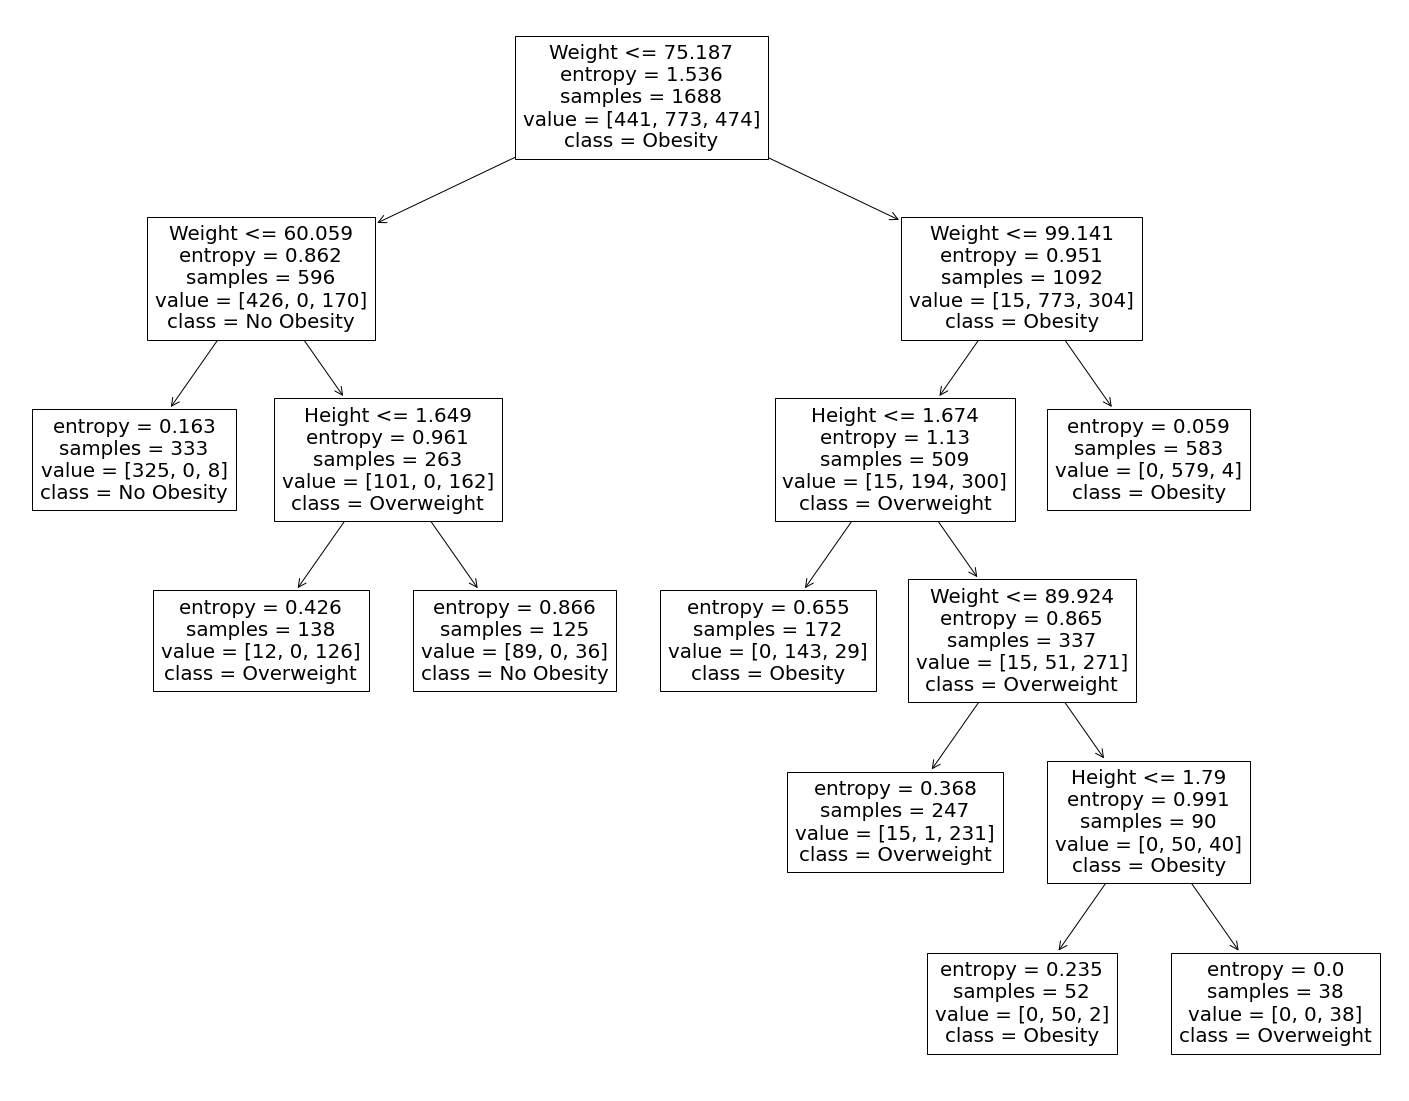

In [779]:
model = DecisionTreeClassifier( criterion = 'entropy', ccp_alpha = 0.01, max_leaf_nodes = 8)
model.fit(obesity_final, obesity_labels)
fig = plt.figure(figsize=(25,20))
_ = plot_tree(model,class_names = obesity_labels.unique(),feature_names = obesity.columns)
cross_val_score(model,obesity_final, obesity_labels,cv = 10)

In [804]:
model.score(obesity_final, obesity_labels)

0.917654028436019

In [780]:
model.feature_importances_

array([0.        , 0.        , 0.15720822, 0.84279178, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [777]:
print(tree.export_text(model,feature_names = [cols for cols in obesity.columns]))

|--- Weight <= 75.19
|   |--- Weight <= 60.06
|   |   |--- Height <= 1.52
|   |   |   |--- class: Overweight
|   |   |--- Height >  1.52
|   |   |   |--- class: No Obesity
|   |--- Weight >  60.06
|   |   |--- Height <= 1.65
|   |   |   |--- Weight <= 64.13
|   |   |   |   |--- Height <= 1.60
|   |   |   |   |   |--- class: Overweight
|   |   |   |   |--- Height >  1.60
|   |   |   |   |   |--- class: No Obesity
|   |   |   |--- Weight >  64.13
|   |   |   |   |--- class: Overweight
|   |   |--- Height >  1.65
|   |   |   |--- Weight <= 72.50
|   |   |   |   |--- class: No Obesity
|   |   |   |--- Weight >  72.50
|   |   |   |   |--- Height <= 1.73
|   |   |   |   |   |--- class: Overweight
|   |   |   |   |--- Height >  1.73
|   |   |   |   |   |--- class: No Obesity
|--- Weight >  75.19
|   |--- Weight <= 99.14
|   |   |--- Height <= 1.67
|   |   |   |--- Weight <= 81.03
|   |   |   |   |--- Height <= 1.63
|   |   |   |   |   |--- class: Obesity
|   |   |   |   |--- Height >  1.63
| 

array([0.93023256, 0.93023256, 0.8372093 , 0.95238095, 0.88095238,
       0.95238095, 0.95238095, 0.97619048, 0.97619048, 0.95238095])

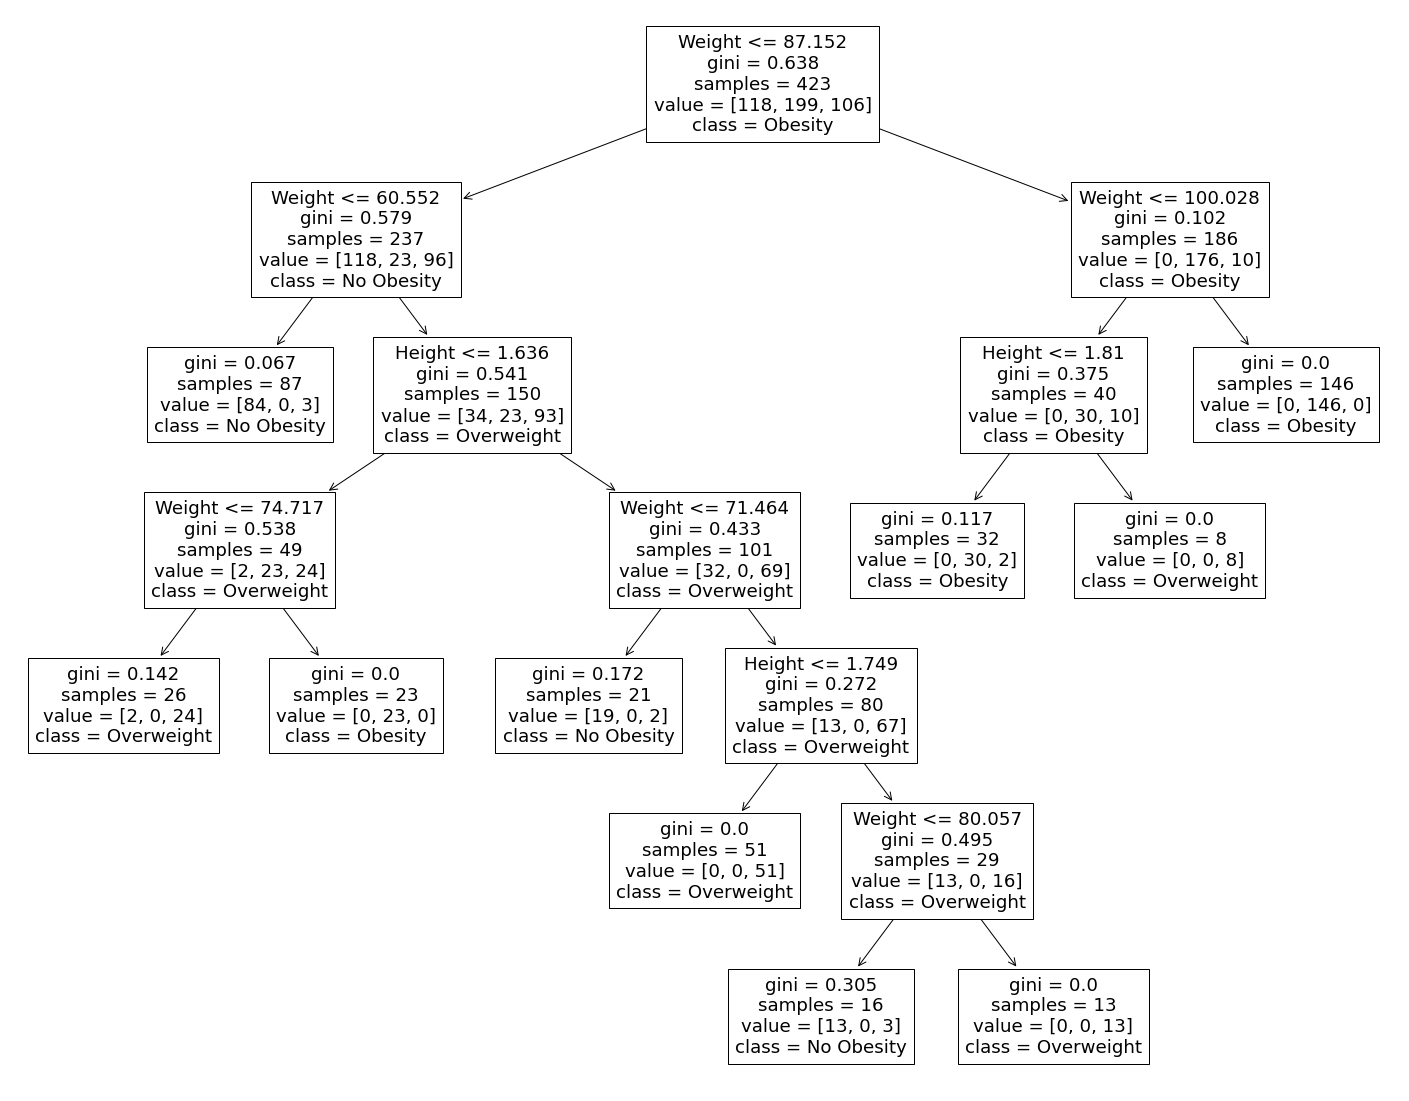

In [830]:
model = DecisionTreeClassifier( ccp_alpha = 0.01)
model.fit(test_obesity_final, test_labels)
fig = plt.figure(figsize=(25,20))
_ = plot_tree(model,class_names = obesity_labels.unique(),feature_names = obesity.columns)
cross_val_score(model,test_obesity_final, test_labels,cv = 10)

In [831]:
print(tree.export_text(model,feature_names = [cols for cols in obesity.columns]))

|--- Weight <= 87.15
|   |--- Weight <= 60.55
|   |   |--- class: No Obesity
|   |--- Weight >  60.55
|   |   |--- Height <= 1.64
|   |   |   |--- Weight <= 74.72
|   |   |   |   |--- class: Overweight
|   |   |   |--- Weight >  74.72
|   |   |   |   |--- class: Obesity
|   |   |--- Height >  1.64
|   |   |   |--- Weight <= 71.46
|   |   |   |   |--- class: No Obesity
|   |   |   |--- Weight >  71.46
|   |   |   |   |--- Height <= 1.75
|   |   |   |   |   |--- class: Overweight
|   |   |   |   |--- Height >  1.75
|   |   |   |   |   |--- Weight <= 80.06
|   |   |   |   |   |   |--- class: No Obesity
|   |   |   |   |   |--- Weight >  80.06
|   |   |   |   |   |   |--- class: Overweight
|--- Weight >  87.15
|   |--- Weight <= 100.03
|   |   |--- Height <= 1.81
|   |   |   |--- class: Obesity
|   |   |--- Height >  1.81
|   |   |   |--- class: Overweight
|   |--- Weight >  100.03
|   |   |--- class: Obesity

